In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d


from fiesta.train.Benchmarker import Benchmarker
from fiesta.inference.lightcurve_model import AfterglowFlux
from fiesta.filters import Filter

## pbag gaussian

In [16]:
FILTERS = ["radio-6GHz", "bessellv", "X-ray-5keV"]


grb_model = AfterglowFlux("pbag_gaussian",
                        "./model", 
                        filters = FILTERS)


benchmarker1 = Benchmarker(model = grb_model,
                           data_file = "../data/pyblastafterglow_raw_data.h5",
                           metric_name = "L2"
                           )


This surrogate pbag_gaussian should only be used in the following parameter ranges:
	 inclination_EM: (0, 1.5707963267948966)
	 log10_E0: (47, 57)
	 thetaCore: (0.01, 0.6283185307179586)
	 alphaWing: (0.2, 3.5)
	 log10_n0: (-6, 2)
	 p: (2.01, 3)
	 log10_epsilon_e: (-4, 0)
	 log10_epsilon_B: (-8, 0)
	 Gamma0: (100, 1000)
Loaded SurrogateLightcurveModel with filters ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].


In [ ]:
Filt = Filter("radio-6GHz")

with h5py.File("../data/pyblastafterglow_raw_data.h5") as f:
    test_y_raw = f["test"]["y"][:]
    test_y_raw = test_y_raw.reshape(-1, 256, 344)
    test_y_raw = interp1d(f["times"][:], test_y_raw, axis = 2)(grb_model.times) # interpolate the test data over the time range of the model
    test_y_raw = interp1d(f["nus"][:], test_y_raw, axis = 1)(grb_model.nus) # interpolate the test data over the time range of the model
    test_y_raw = test_y_raw.reshape(-1,len(grb_model.times) * len(grb_model.nus))
    
reconstructed_y = grb_model.y_scaler.inverse_transform(grb_model.y_scaler.transform(test_y_raw))


In [ ]:
mJys = np.exp(reconstructed_y.reshape(-1, len(grb_model.nus), len(grb_model.times)))

In [15]:
reconstructed_mag = Filt.get_mags(mJys[:], grb_model.nus)

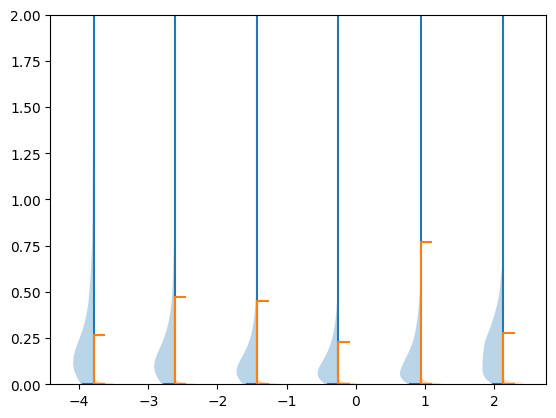

In [20]:
fig, ax = plt.subplots(1,1)
filter = "radio-6GHz"

error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
indices = np.linspace(10, len(grb_model.times)-10, 6).astype(int)

ax.violinplot(error[:, indices], positions=np.log10(grb_model.times[indices]), widths=0.6, side="low", showextrema=True, points=500)

error = np.abs(benchmarker1.test_mag[filter] - reconstructed_mag)
ax.violinplot(error[:, indices], positions=np.log10(grb_model.times[indices]), widths=0.6, side="high", showextrema=True, points=500)

ax.set_ylim(0, 2)

fig.show()

In [33]:
grb_model.y_scaler.transform(test_y_raw[0])[0]

Array([ 3.95080322e+03, -2.30794525e+02, -1.08132835e+02, -9.75497055e+01,
       -1.82290146e+02, -2.41677292e+02, -2.83803177e+01, -1.14041031e+02,
       -6.13823280e+01, -6.69022598e+01, -1.96515408e+01,  2.96853008e+01,
        1.49598627e+01, -1.63055687e+01,  2.09274902e+01,  5.63482952e+00,
       -4.43162823e+00, -2.74467158e+00, -1.85591469e+01, -7.08726931e+00,
        1.91164637e+00,  1.27539215e+01, -5.16464043e+00,  2.75991273e+00,
        2.61082435e+00,  5.64798975e+00, -1.00887852e+01, -1.86355507e+00,
       -3.01176524e+00,  1.47999401e+01, -1.22020617e+01,  7.55687475e+00,
        1.97649395e+00,  5.06234884e+00,  9.93645191e+00, -2.32914424e+00,
       -1.03159100e-02,  5.35022020e+00, -4.22686005e+00, -7.74007022e-01,
        2.73939753e+00,  1.02465677e+00,  2.05003715e+00, -3.67360473e-01,
        3.29852939e+00, -2.35570884e+00,  1.69040132e+00, -1.78663230e+00,
       -1.68660328e-01,  1.69182575e+00,  1.09442759e+00,  1.32164264e+00,
        1.40767682e+00,  

(0.0, 200.0)

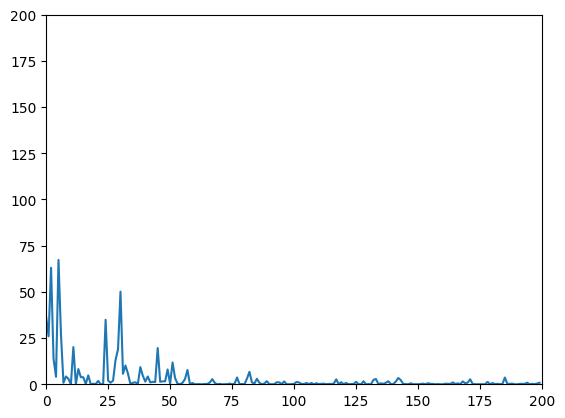

In [ ]:
plt.plot((grb_model.compute_output(grb_model.project_input(benchmarker1.test_X_raw[0]))  - grb_model.y_scaler.transform(test_y_raw[0])[0])**2)
plt.xlim(0, 200)
plt.ylim(0, 200)

(0.0, 2.0)

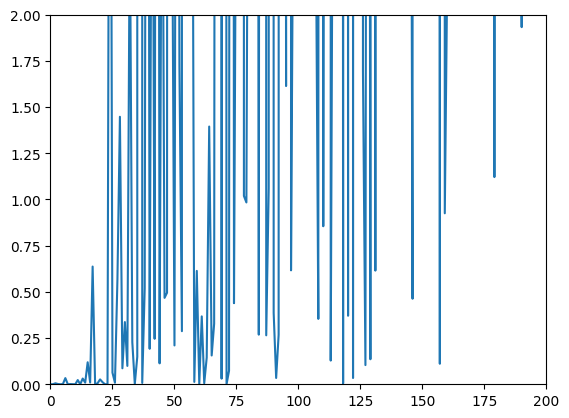

In [117]:
plt.plot((grb_model.compute_output(grb_model.project_input(benchmarker1.test_X_raw[0]))  - grb_model.y_scaler.transform(test_y_raw[0])[0])**2  / grb_model.y_scaler.transform(test_y_raw[0])[0]**2 )
plt.xlim(0, 200)
plt.ylim(0, 2)

In [53]:
def model_pca_pred(x):
    return grb_model.compute_output(grb_model.project_input(x))

def pca_comp_to_mag(pca_comp):

    log_flux = grb_model.y_scaler.inverse_transform(pca_comp)
    mJys = np.exp(log_flux).reshape(len(grb_model.nus), len(grb_model.times))

    mag = Filter("radio-6GHz").get_mag(mJys, grb_model.nus)

    return mag


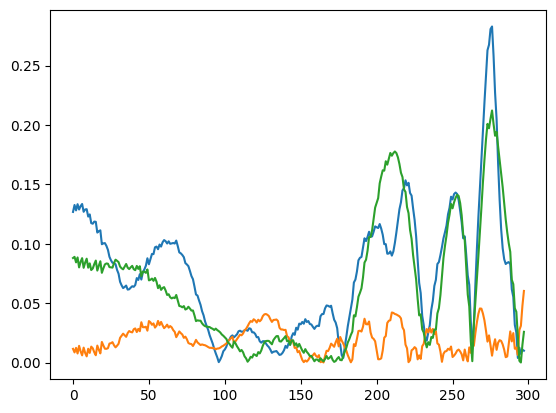

In [118]:
test_ind = 0

pca_pred = model_pca_pred(benchmarker1.test_X_raw[test_ind])
pca_test = grb_model.y_scaler.transform(test_y_raw[test_ind])[0]




error =  np.abs(benchmarker1.test_mag["radio-6GHz"][test_ind] - pca_comp_to_mag(pca_pred) )
plt.plot(error)


new_pca = pca_pred.at[:50].set(pca_test[:50])
new_pca = new_pca.at[50:].set(0)

error =  np.abs(benchmarker1.test_mag["radio-6GHz"][test_ind] - pca_comp_to_mag(new_pca) )
plt.plot(error)

error =  np.abs(benchmarker1.test_mag["radio-6GHz"][test_ind] - pca_comp_to_mag(pca_pred.at[50:].set(pca_test[50:])) )
plt.plot(error)

In [50]:
pca_comp_to_mag(grb_model.y_scaler.transform(test_y_raw[1]))

Array([ -6.656857 ,  -6.805372 ,  -6.9604955,  -7.108269 ,  -7.264622 ,
        -7.414726 ,  -7.566314 ,  -7.724579 ,  -7.8761587,  -8.030862 ,
        -8.19223  ,  -8.345459 ,  -8.509542 ,  -8.663972 ,  -8.819006 ,
        -8.976753 ,  -9.141158 ,  -9.297731 ,  -9.453731 ,  -9.616911 ,
        -9.771923 ,  -9.927007 , -10.081237 , -10.235519 , -10.395006 ,
       -10.544548 , -10.694466 , -10.841879 , -10.988836 , -11.130718 ,
       -11.273305 , -11.421643 , -11.557433 , -11.690945 , -11.821893 ,
       -11.952447 , -12.07601  , -12.197094 , -12.318765 , -12.435448 ,
       -12.54682  , -12.645615 , -12.757376 , -12.85998  , -12.963917 ,
       -13.04897  , -13.141834 , -13.233054 , -13.320146 , -13.401365 ,
       -13.468095 , -13.551059 , -13.619627 , -13.694111 , -13.763681 ,
       -13.820904 , -13.886482 , -13.949792 , -14.011729 , -14.0707035,
       -14.127164 , -14.175324 , -14.223121 , -14.277732 , -14.332771 ,
       -14.3778105, -14.427315 , -14.474703 , -14.514327 , -14.5

In [51]:
benchmarker1.test_mag["radio-6GHz"][0]

Array([49.734585 , 49.5749   , 49.415264 , 49.255577 , 49.095894 ,
       48.936253 , 48.776566 , 48.616886 , 48.457233 , 48.29757  ,
       48.137897 , 47.97821  , 47.818558 , 47.658882 , 47.499203 ,
       47.339558 , 47.179882 , 47.020184 , 46.860523 , 46.70088  ,
       46.5412   , 46.381508 , 46.221878 , 46.062183 , 45.902504 ,
       45.74286  , 45.58318  , 45.423515 , 45.26382  , 45.104187 ,
       44.9445   , 44.784813 , 44.62518  , 44.465485 , 44.30581  ,
       44.14616  , 43.986492 , 43.826813 , 43.66713  , 43.507484 ,
       43.347805 , 43.18813  , 43.028473 , 42.868793 , 42.70911  ,
       42.54945  , 42.389797 , 42.230114 , 42.070435 , 41.91079  ,
       41.75111  , 41.591427 , 41.43178  , 41.272106 , 41.11242  ,
       40.95275  , 40.793106 , 40.633427 , 40.473736 , 40.314102 ,
       40.15441  , 39.99473  , 39.835083 , 39.675407 , 39.51573  ,
       39.35605  , 39.19641  , 39.036728 , 38.877045 , 38.717403 ,
       38.557713 , 38.39803  , 38.23838  , 38.07872  , 37.9190